In [1]:
import importlib
import os
import argparse
import time

from torchvision import datasets
from torchvision import transforms
import torch
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import datasets as ds
import models
import utils
from PoseExtraction import PoseNormalization
from multiPoseExtraction import MultiPoseExtraction

import matplotlib.pyplot as plt
import glob
import imageio
import matplotlib.patches as patches
import cv2
import numpy as np 

def crop_face(img, x, y, width, height):
    return img[y - height: y + height, x - width: x + width, :]

def parse_num(num_string):
    previous_sign = 1
    parse_str = ""
    final_nums = []
    num_sign = ['-', '+']
    for c in num_string:
        if c in num_sign:
            if parse_str == "":
                pass
            else:
                final_nums.append(int(parse_str)*previous_sign)
                parse_str = ""
            if c == '-':
                previous_sign = -1
            elif c == '+':
                previous_sign = 1
        else:
            parse_str += c
            
    return final_nums

def plot_head(example_img, position, size, ax):  
    width, height, channels = example_img.shape
    head_width = example_person['position'][0]
    head_height = example_person['position'][1]
    position = (head_width - (example_person['size'][0]/2), head_height - (example_person['size'][1]/2))
    
    ax.imshow(example_img)
    rect = patches.Rectangle(position, *example_person['size'],
                             linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.boxplot
    return ax

In [2]:
people = glob.glob('./data/HeadPoseImageDatabase/*/')
people = [file_name.split('/')[-2] for file_name in people if 'Person' in file_name]

file_dict = {}
for person_id in people:
    file_dict[person_id] = {}
    picture_files = glob.glob('./data/HeadPoseImageDatabase/{}/*.jpg'.format(person_id))
    for complete_file_name in picture_files:
        new_delimeter = ';'
        file_name = complete_file_name.split('/')[-1]
        cleaned_file_name = file_name.replace('-', new_delimeter).replace('+', new_delimeter)
        base_name = cleaned_file_name.split(new_delimeter)[0]
        meta_data = file_name[len(base_name):].split('.jpg')[0]+'+'
        tilt, pan = parse_num(meta_data)
        txt_file = glob.glob('./data/HeadPoseImageDatabase/{}/{}*.txt'.format(person_id, base_name))[0]
        if base_name not in file_dict:
            with open(txt_file, 'r') as f:
                result = f.readlines()
                result = [line.replace('\n', '') for line in result]
                position = np.array((int(result[3]), int(result[4])))
                size = np.array((int(result[5]), int(result[6])))
                file_dict[person_id][base_name] = {'image': complete_file_name, 'position':position, 'size': size,
                                                  'tilt': tilt, 'pan':pan}
    

[102 124]


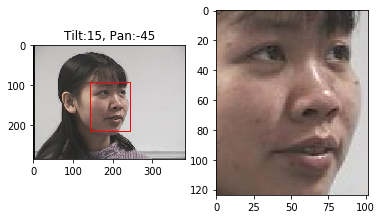

In [3]:
person_id = 'Person03'
example_person = list(file_dict[person_id].keys())[4]
example_person = file_dict[person_id][example_person]   
example_img = imageio.imread(example_person['image'])
print(example_person['size'])
cropped_face = crop_face(example_img, *example_person['position'], *((example_person['size']/2).astype(int)))
fig, ax = plt.subplots(1, 2)
ax[0].set_title("Tilt:{}, Pan:{}".format(example_person['tilt'], example_person['pan']))
plot_head(example_img, example_person['position'], example_person['size'], ax[0])
ax[1].imshow(cropped_face)

(1860, 3, 64, 64) (1860, 2) (64, 64)
torch.Size([1860, 3, 64, 64])
torch.Size([1860, 2])
torch.Size([930, 3, 64, 64])
torch.Size([930, 2])
tensor([[  0., -30.],
        [ 30., -90.],
        [ 15., -45.],
        [ 60.,  90.],
        [ 30.,  75.],
        [-60.,  30.],
        [ 30.,  60.],
        [-30.,  60.],
        [  0.,  30.],
        [ 60., -75.]])


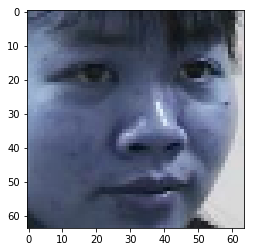

In [2]:
from models.headPose import PINNBasic, STNBasic, CNNBasic, MultiPINNBasic
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader, dataset_details = ds.headPose()
batch_size, channel_num, height, width = dataset_details

index2 = 0
for img, label in train_loader:
    break
    
fig, ax = plt.subplots()
ax.imshow(utils.tensor_to_numpy_img(img[index2:index2+1]))

cnn = CNNBasic().to(device)
pinn = MultiPINNBasic().to(device)
# stn = STNBasic().to(device)
criterion_cnn = nn.MSELoss()
criterion_pinn = nn.MSELoss()
# criterion_stn = nn.MSELoss()

In [4]:
learning_rate = 0.001
batch_num = 40
epoch_num = 15
optimizer_pinn = torch.optim.Adam([param for param in pinn.parameters() if param.requires_grad], 
                                  lr=learning_rate)
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
pinn, pinn_loss, pinn_acc, _ = utils.train_net(pinn, train_loader, test_loader, criterion_pinn, optimizer_pinn, batch_num, epoch_num)
# cnn, cnn_loss, cnn_acc = utils.train_net(cnn, train_loader, test_loader, criterion_cnn, optimizer_cnn, batch_num, epoch_num)

TOTAL TRAIN 1280
TOTAL VALIDATION 372
TOTAL TEST 930
Loss: 51.3275505065918, Acc: 0.0, Validation Loss: 46.29845403855847
Loss: 53.073189640045165, Acc: 0.0, Validation Loss: 44.839188442435315
Loss: 50.93909063339233, Acc: 0.0, Validation Loss: 46.40814110540575
Loss: 49.90738687515259, Acc: 0.0, Validation Loss: 42.99860702022429
Loss: 49.02613849639893, Acc: 0.0, Validation Loss: 63.76806214035198
Loss: 66.28829984664917, Acc: 0.0, Validation Loss: 96.81933199974799
Loss: 78.89422130584717, Acc: 0.0, Validation Loss: 74.58351315734207
Loss: 71.9678147315979, Acc: 0.0, Validation Loss: 79.5499510406166
Loss: 67.40384140014649, Acc: 0.0, Validation Loss: 69.7241453765541
Loss: 65.61675128936767, Acc: 0.0, Validation Loss: 68.90563308551748
Loss: 65.31084690093994, Acc: 0.0, Validation Loss: 71.79937284736224
Loss: 63.07100429534912, Acc: 0.0, Validation Loss: 71.75638670562417
Loss: 61.85478553771973, Acc: 0.0, Validation Loss: 62.830220540364586
Loss: 72.79976682662964, Acc: 0.0, Val

[11.218850790044312,
 10.939263423796623,
 10.640095520019532,
 10.61687953497774,
 11.648571670696299]

In [6]:
# print(pinn.pose_norm.channel_compress.conv2d.weight.shape)

# class PoseSubNet(nn.Module):
#     def __init__(self):
#         super(PoseSubNet, self).__init__()
#         self.net = nn.Sequential(pinn.features1)
    
#     def forward(self, x):
#         x = self.net(x)
#         _, means, orientations, confidence, theta, (L1, L2) = pinn.pose_norm(x)
#         x = pinn.pose_norm.channel_compress(x)
#         return x, means, orientations, confidence, theta, (L1, L2)
    
# pre_pose = PoseSubNet()

class MulitPoseSubNet(nn.Module):
    def __init__(self):
        super(MulitPoseSubNet, self).__init__()
        self.net = nn.Sequential(pinn.features1)
    
    def forward(self, x):
        x = self.net(x)
        means, orientations, mu_avg, T_orig, theta, (L1, L2) = pinn.multi_pose(x)
        return x, means, orientations, (L1, L2)
    
pre_pose = MulitPoseSubNet()

pre_index = 10
for temp_index, (img, label) in enumerate(train_loader):
    img_batch = img
    label_batch = label
    if pre_index == temp_index:
        break
        

Parameter containing:
tensor([[[[ 0.9931]]]], device='cuda:0')


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


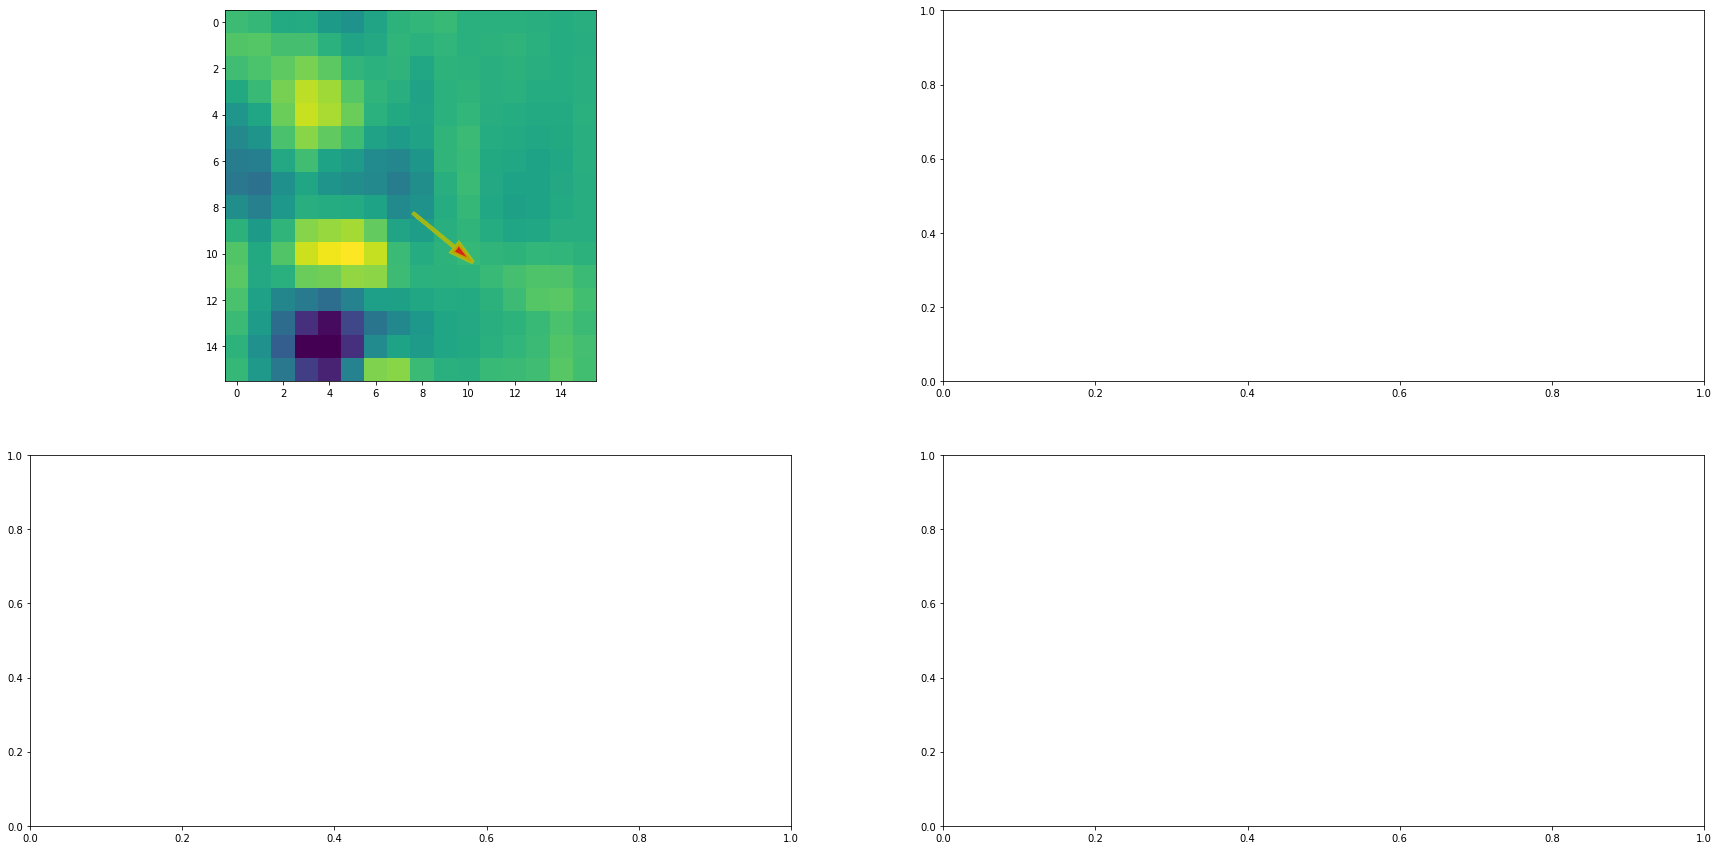

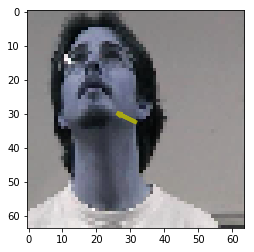

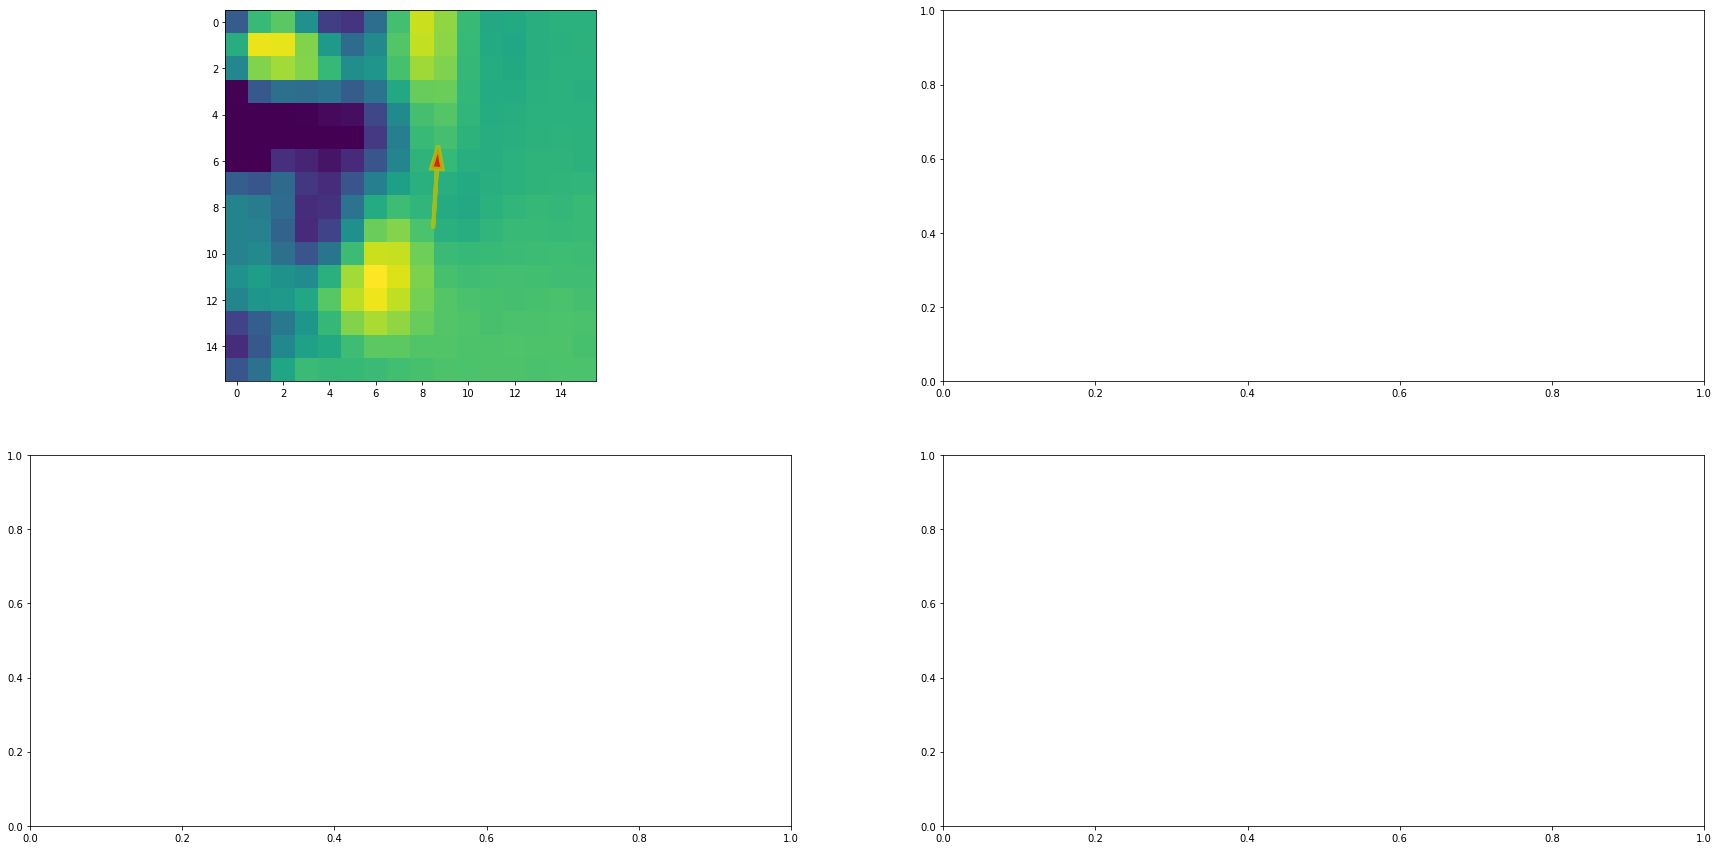

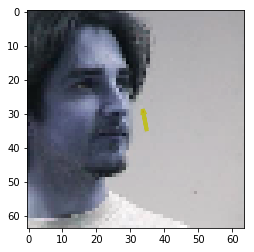

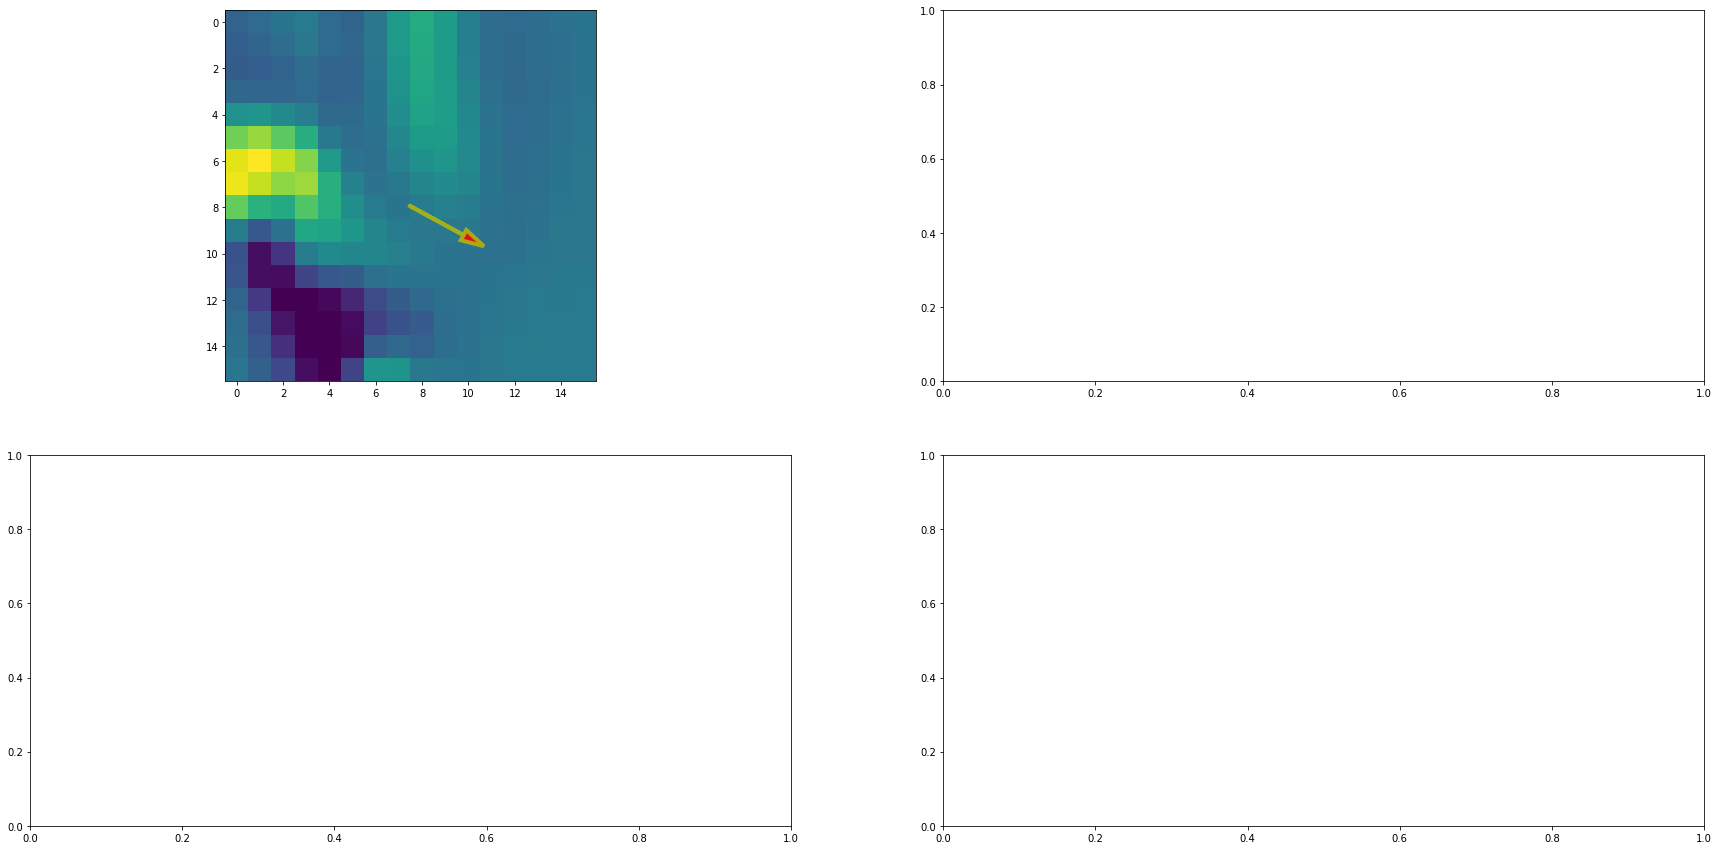

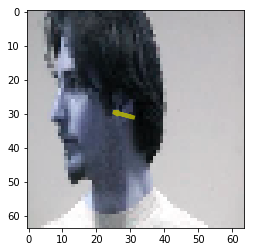

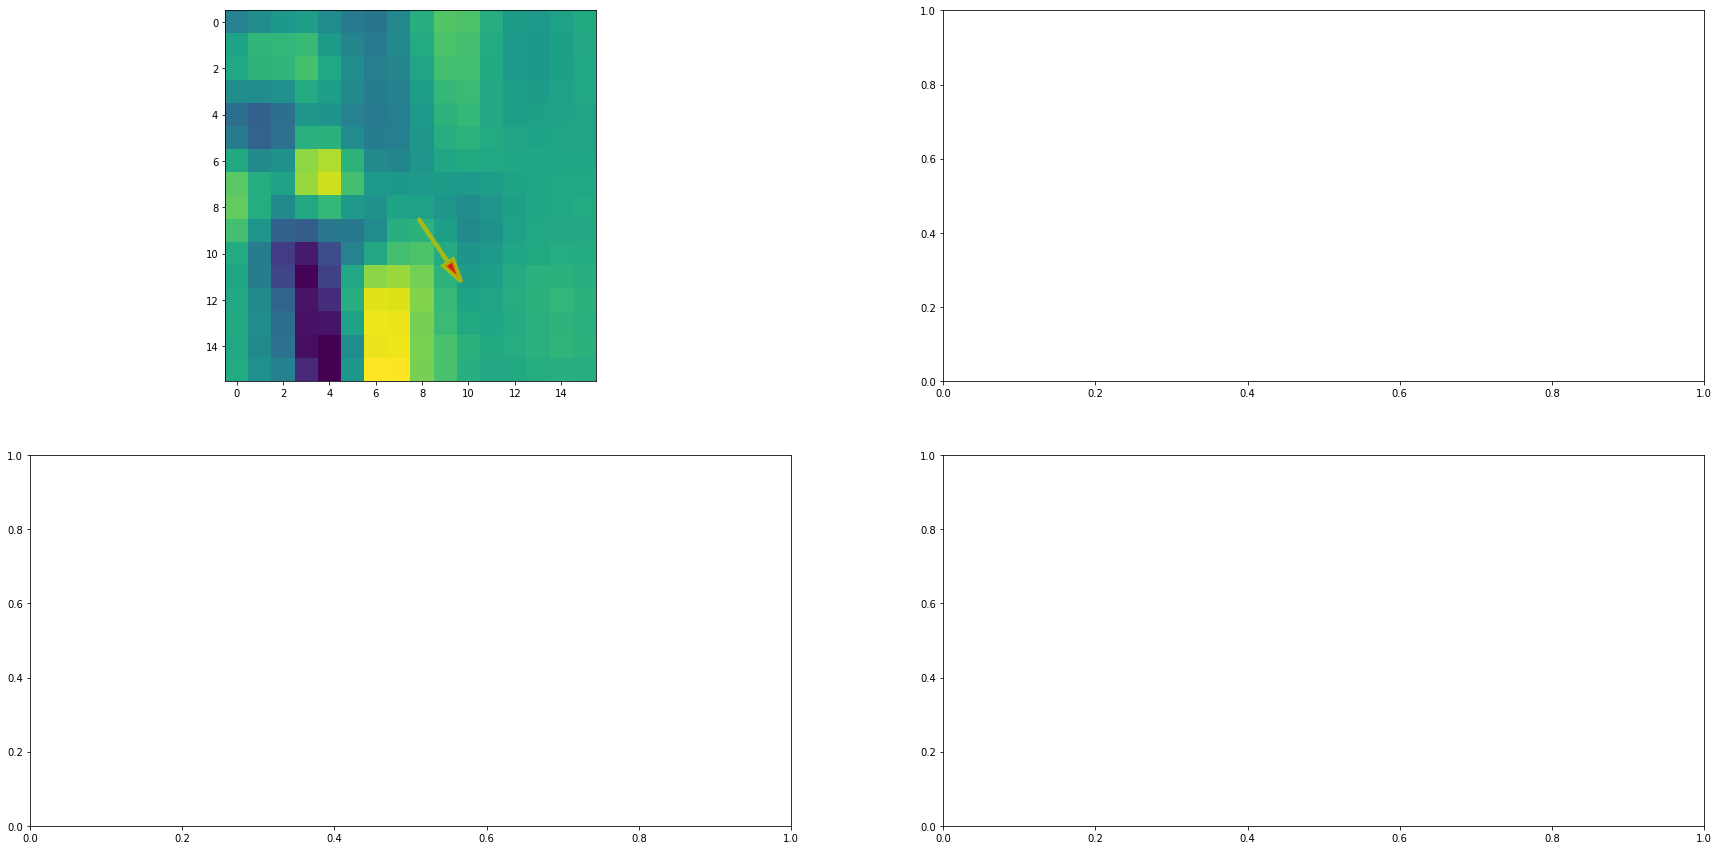

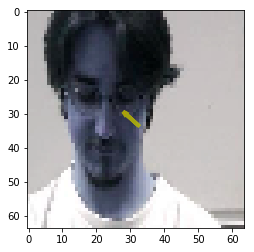

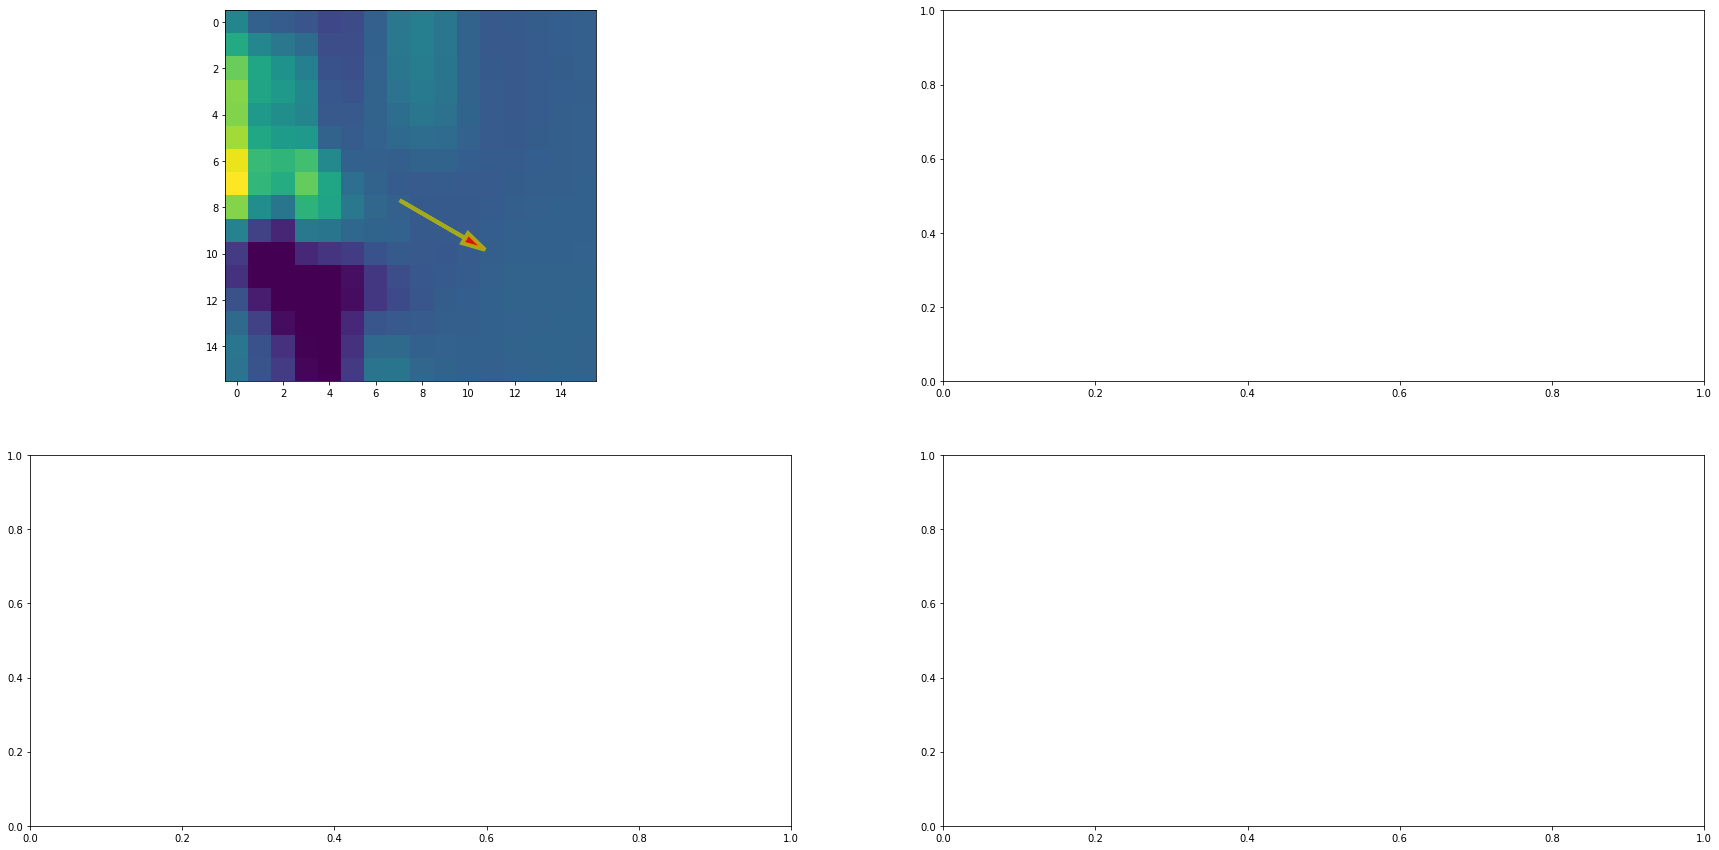

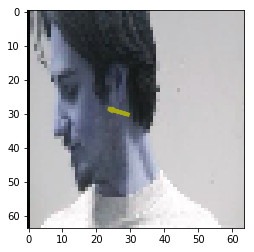

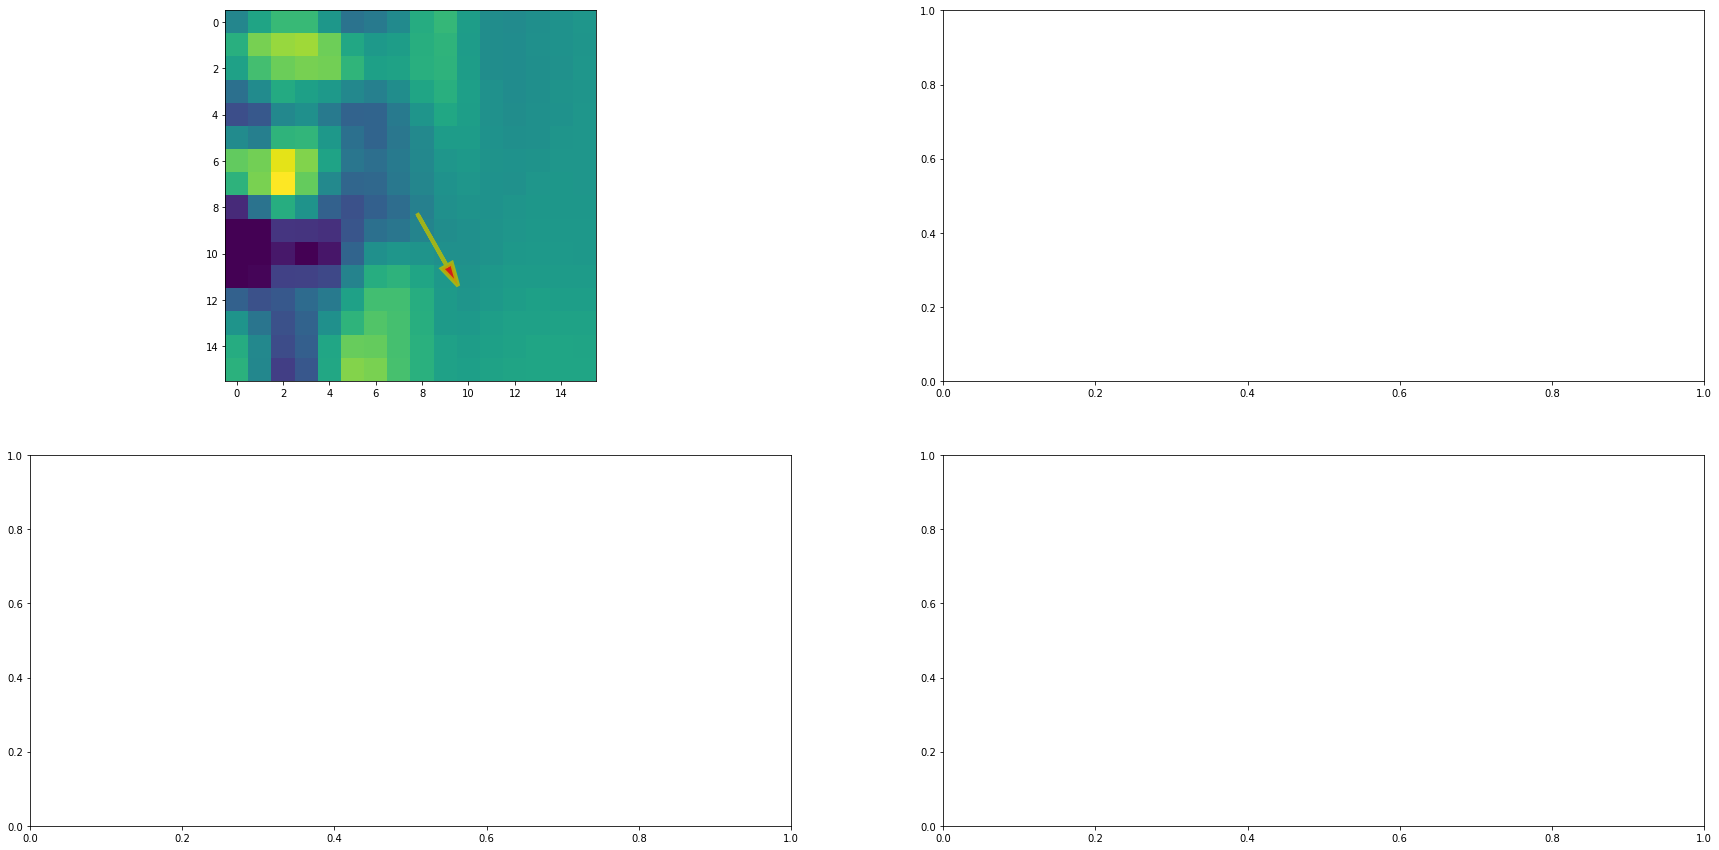

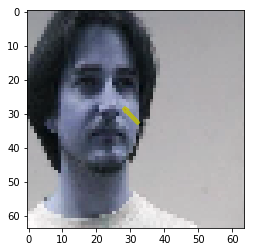

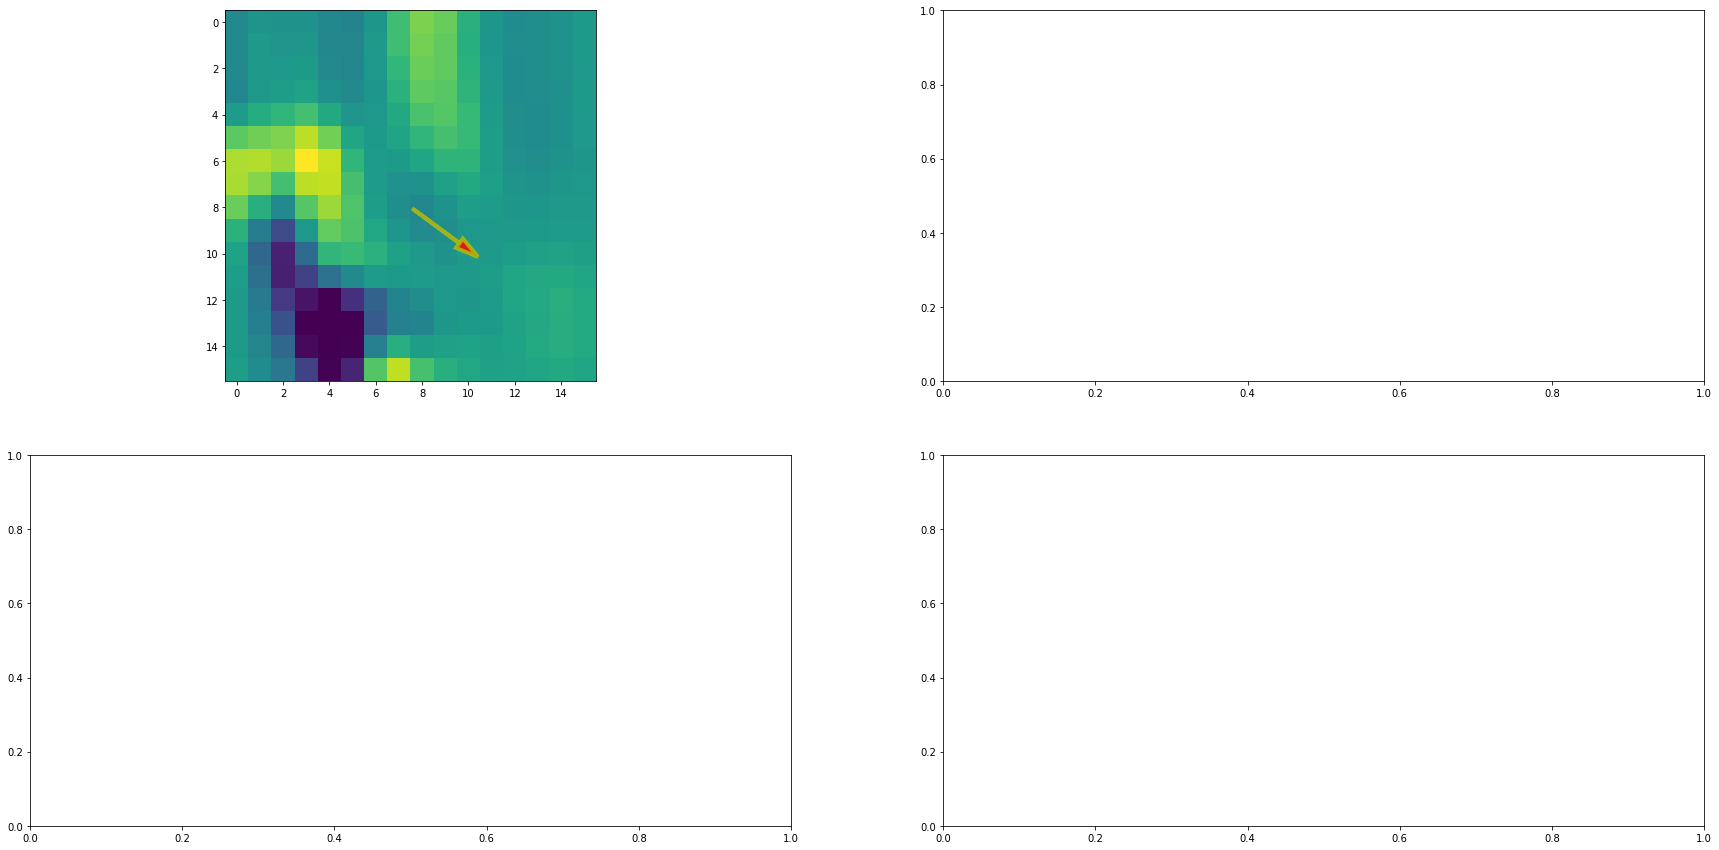

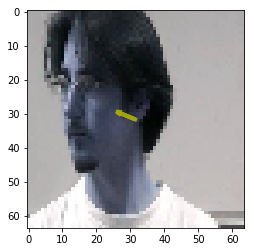

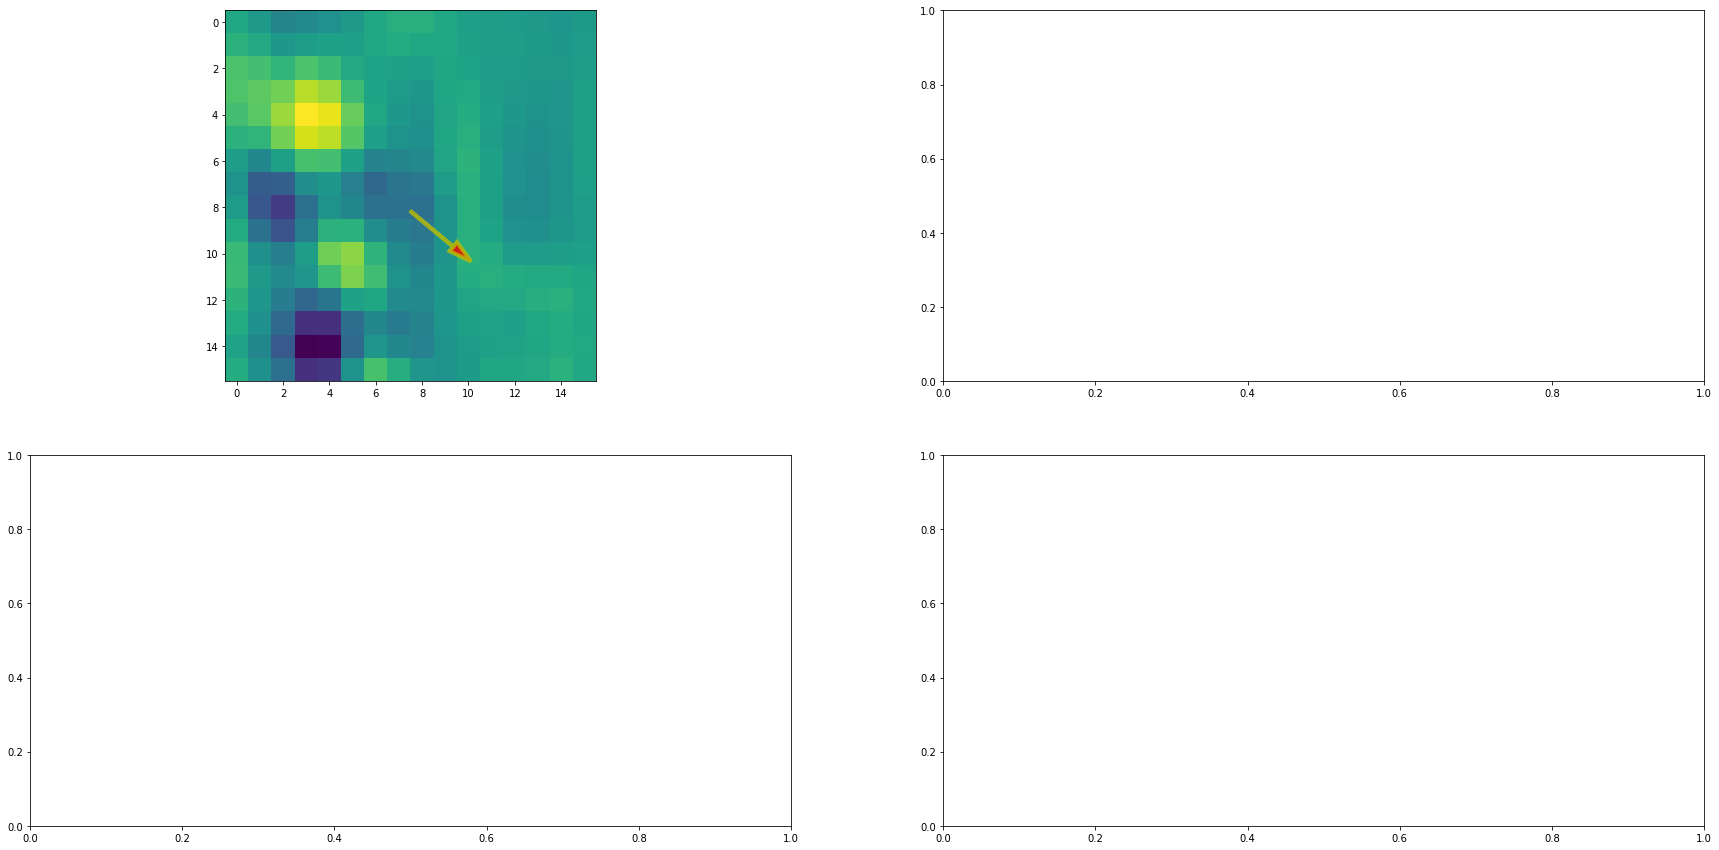

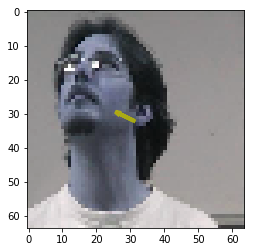

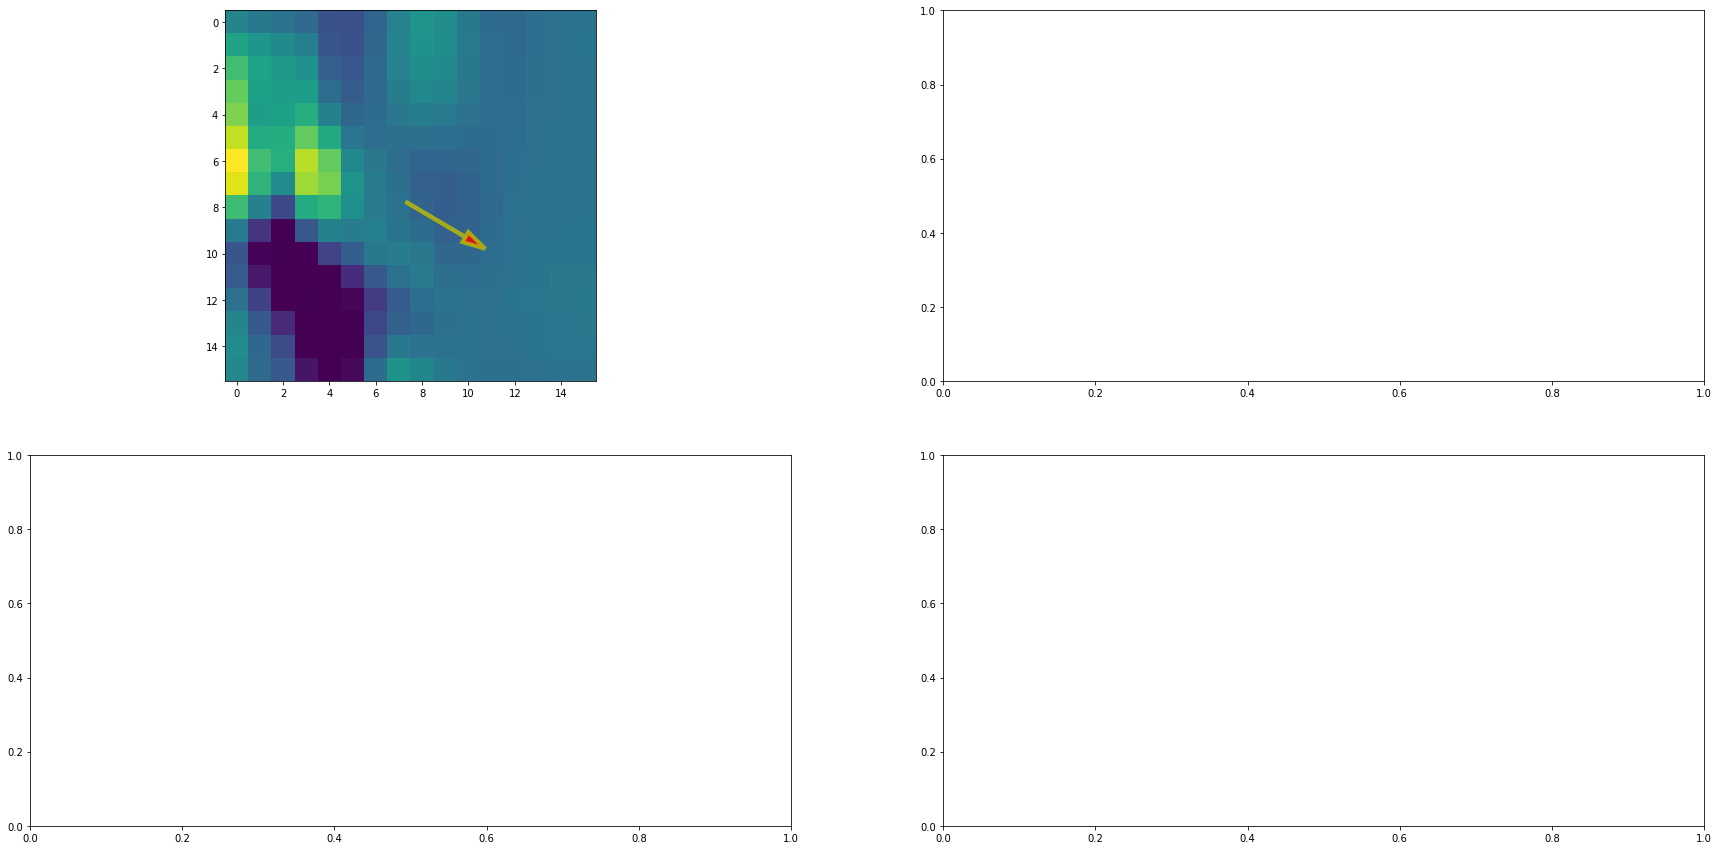

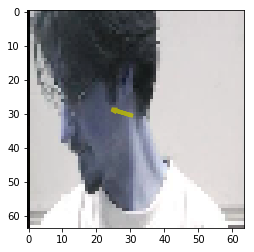

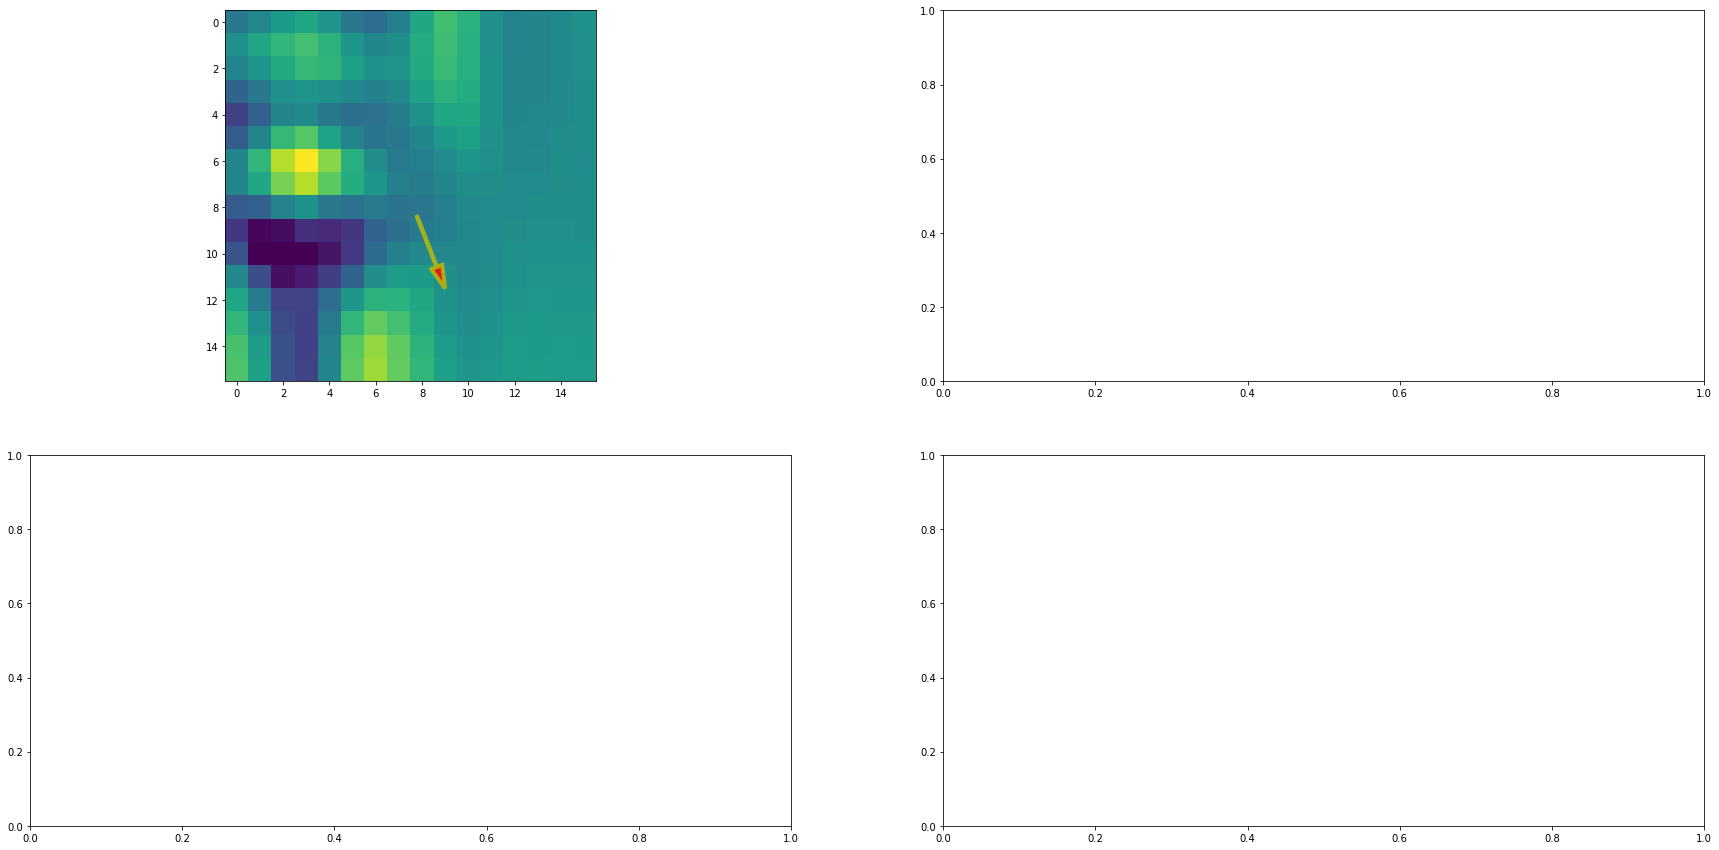

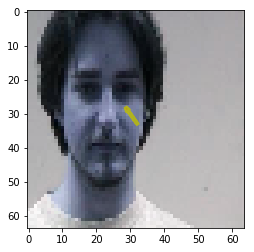

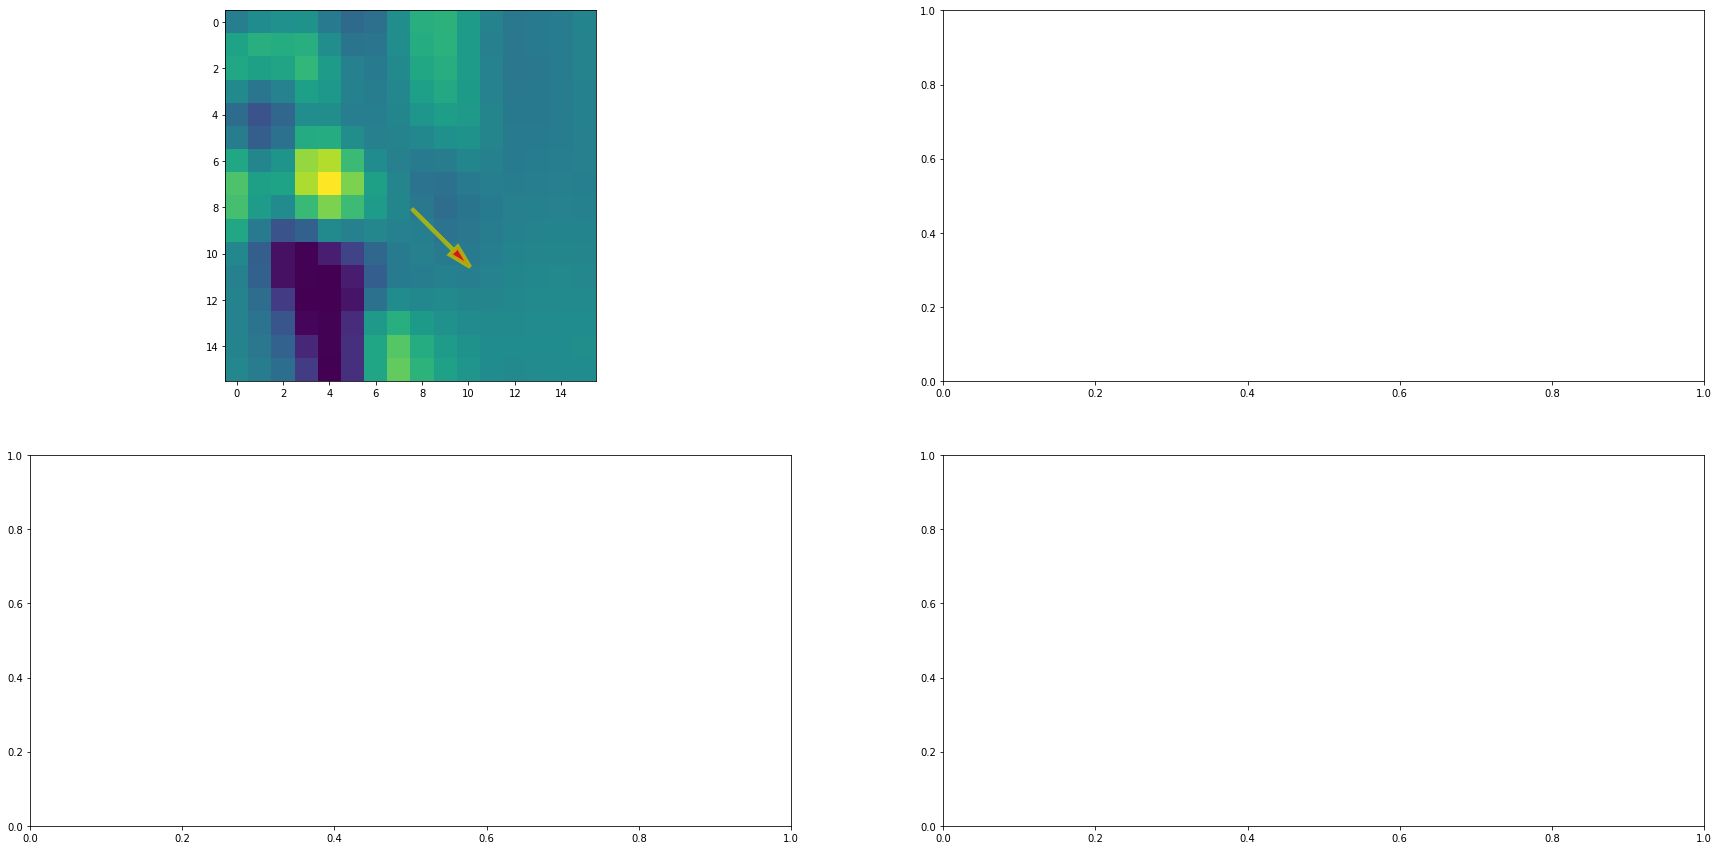

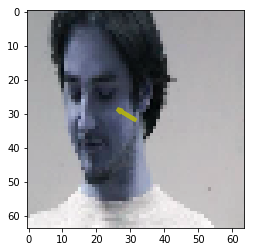

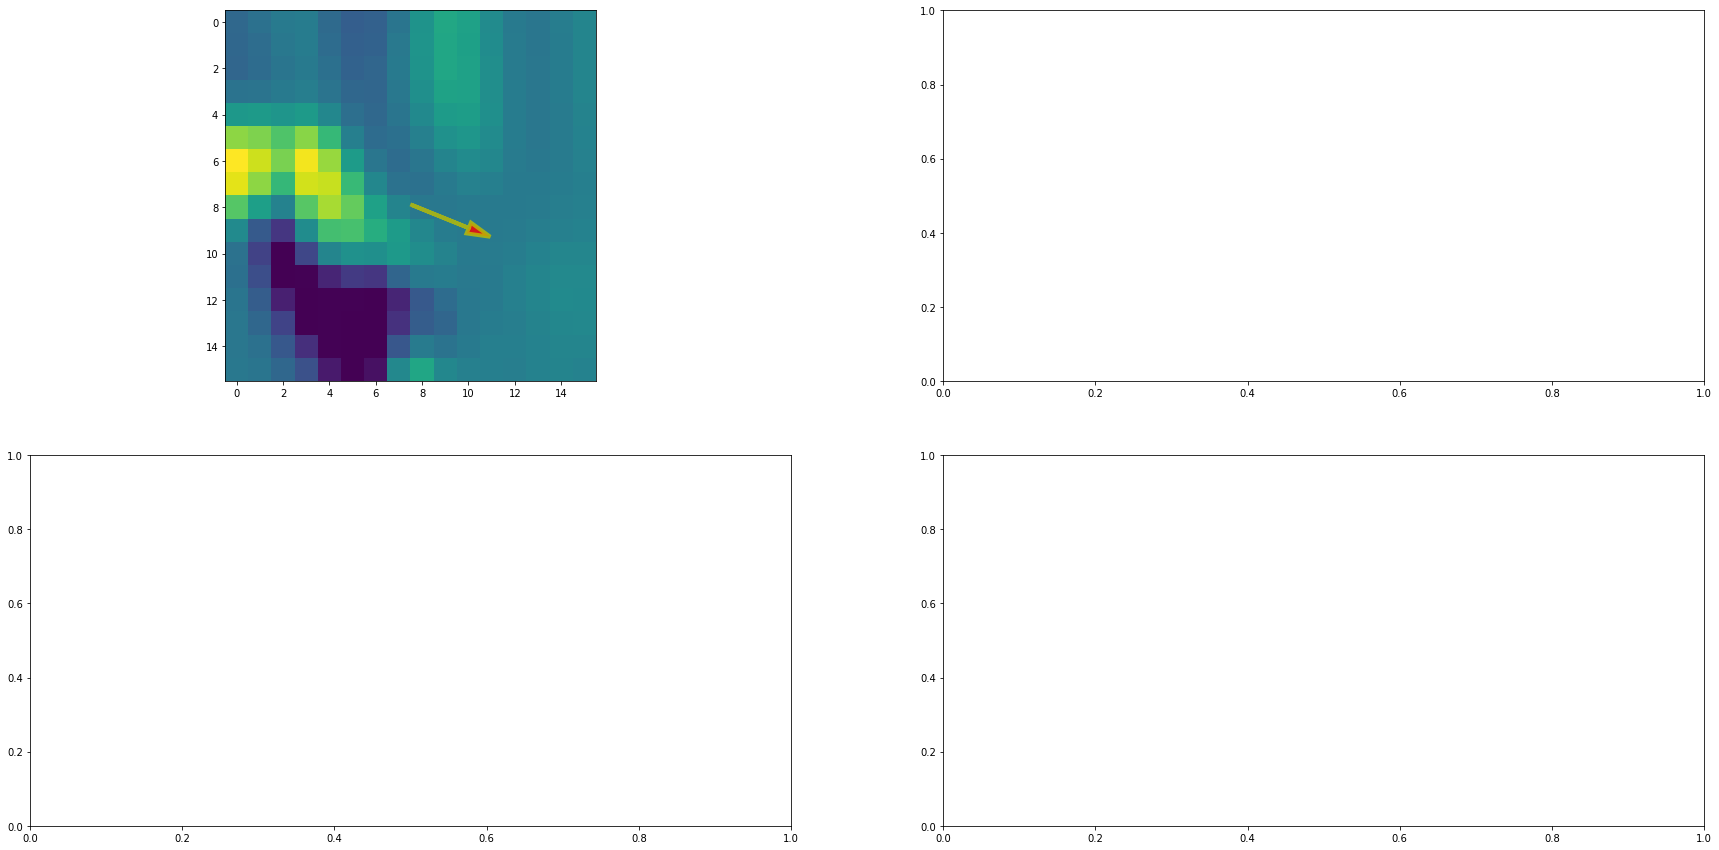

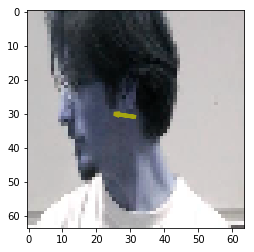

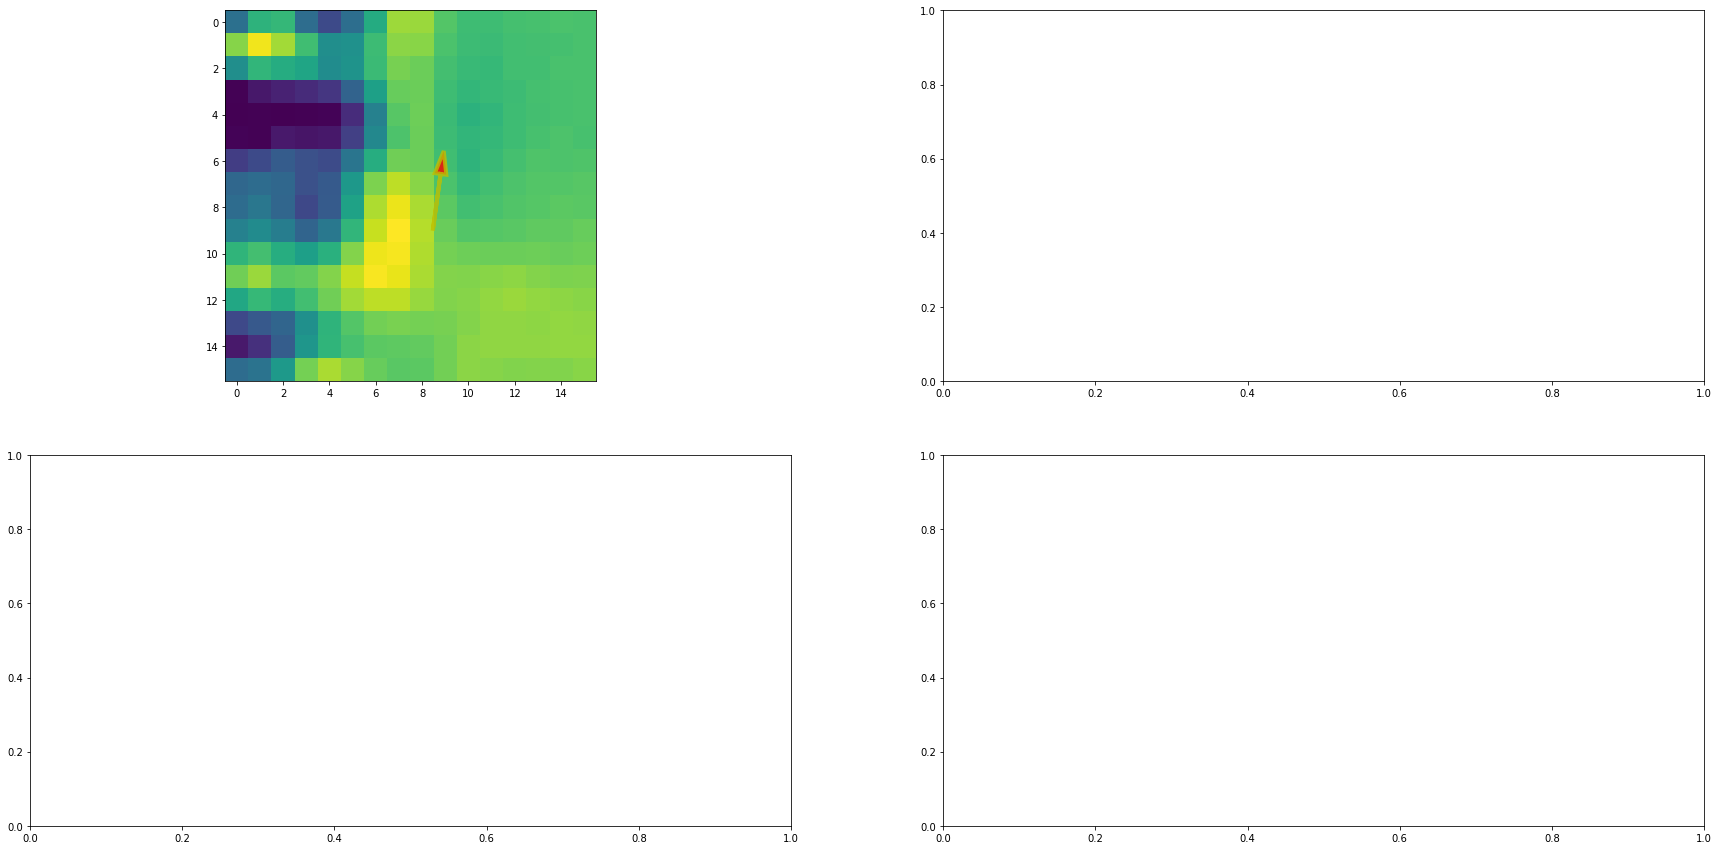

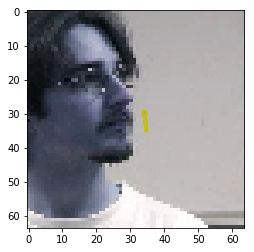

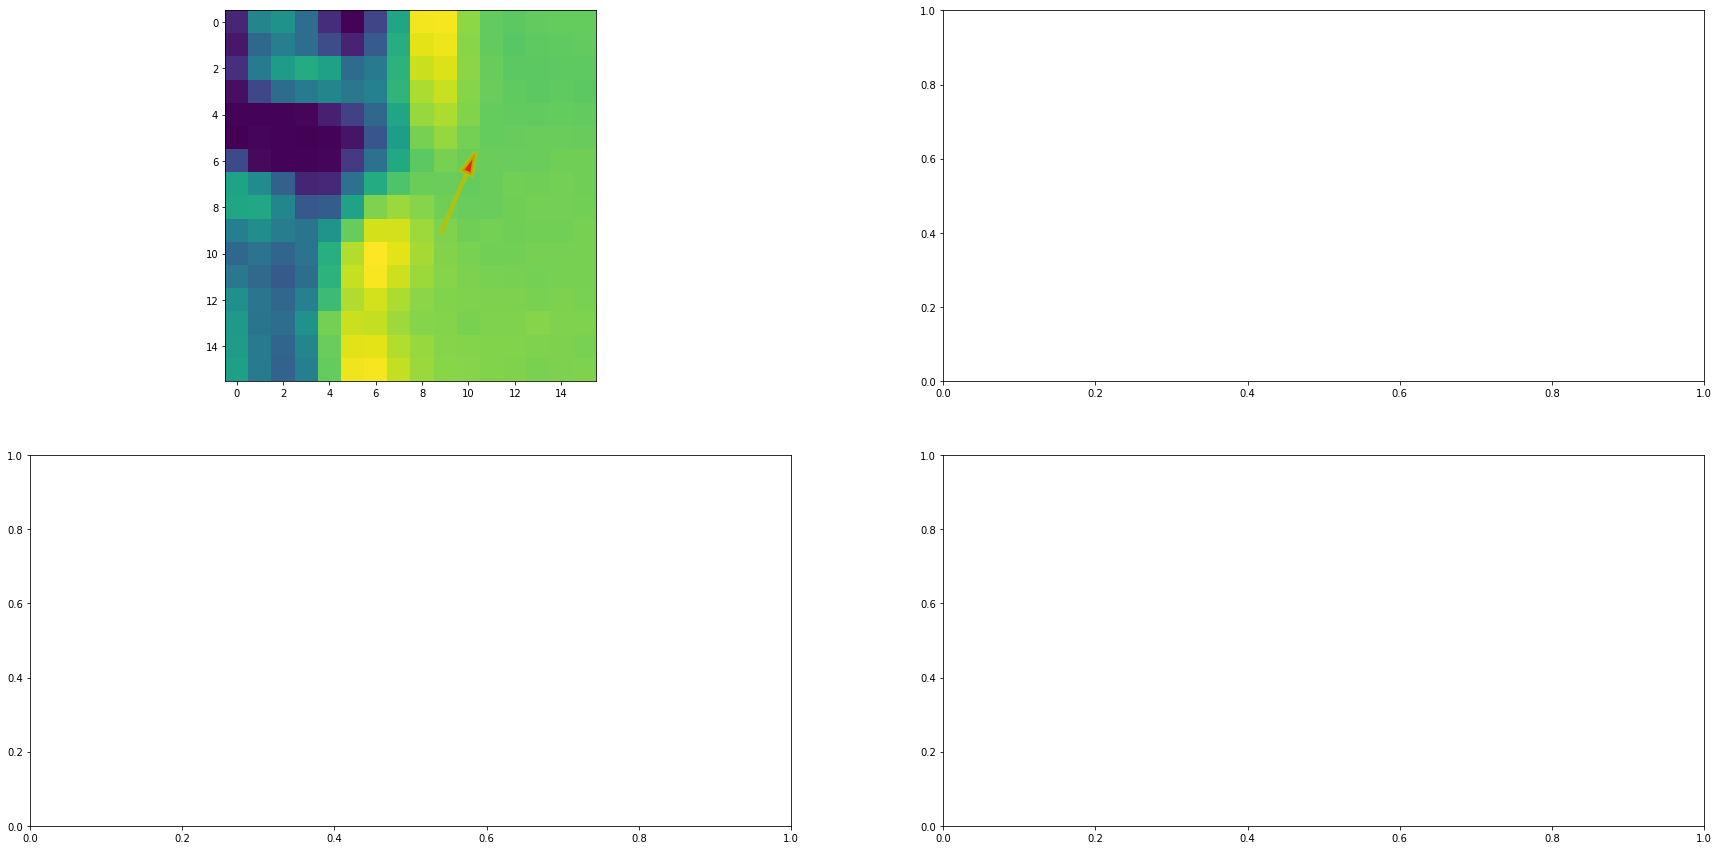

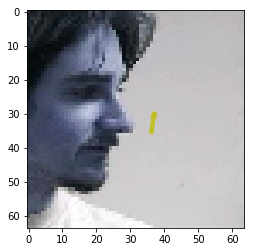

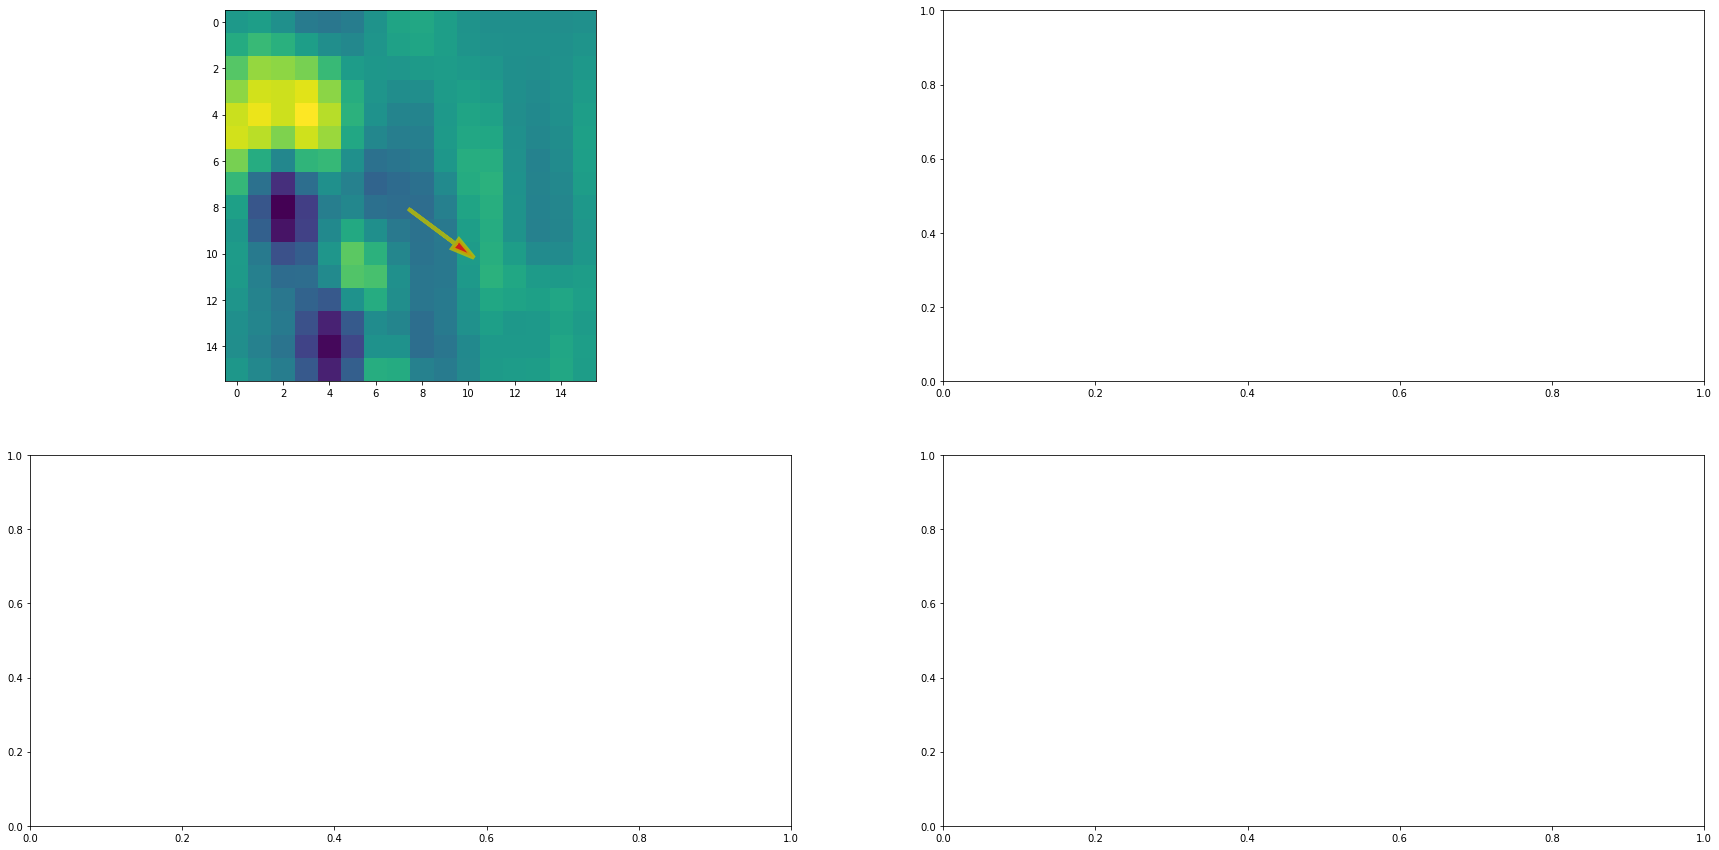

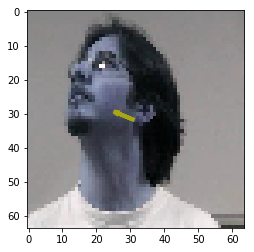

In [10]:
import importlib

pose_extractor = PoseNormalization(1, (16, 16)).to(device)
# multi_pose_extractor = MultiPoseExtraction(32).to(device)
def plot_arrow_img(ax, means, orientations, img_shape, arrow_scale=2, color='r'):
    mean_x = means[0, 0, 0].cpu().data.numpy()
    mean_y = means[0, 1, 0].cpu().data.numpy()

    rot = orientations[0].cpu().data.numpy()
    arrow_start = (mean_x, img_shape[1] - mean_y)
    arrow_end = (rot[0, 0]*arrow_scale, -1*rot[0, 1]*arrow_scale)

    #         ax[index % row_length].arrow(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], 
    #                     head_width=0.5, head_length=1, fc='red', ec='r', linewidth=4, alpha=1)

    ax.arrow(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], 
                head_width=0.5, head_length=1, fc='red', ec=color, linewidth=4, alpha=0.8)

print(pinn.multi_pose.conv2d.weight)
for index in range(15):
    
    index += 0
    first_features = pinn.heatmap(pinn.features1(img_batch[index:index+1].cuda()))
    means2, orientations2, mu_avg, T_orig, theta, (L1, L2) = pinn.multi_pose(first_features)
    #     x, means_orig, orientations_orig, (L1, L2) = pre_pose(img_batch[index:index+1].cuda())
    row_num, col_num = (2, 2)
    fig2, ax2 = plt.subplots(row_num, col_num, figsize=(30, 15))
#     print(first_features.shape)
    
#     for i2 in range(first_features.shape[1]):
#         print(x[0, i2].shape)
        
#     ax2[1].imshow(utils.tensor_to_numpy_img(torch.zeros(16, 16)+0.01))

#     row_length = 5
    fig, ax = plt.subplots()
    ax.imshow(utils.tensor_to_numpy_img(img_batch[index:index+1]))
    orientation = theta[:, :, 0].unsqueeze(0)
    new_orientation = torch.Tensor([[[orientation[0, 0, 1].item(), orientation[0, 0, 0].item()]]])
    plot_arrow_img(ax, 4*mu_avg, new_orientation, 
                       (64, 64), 5, 'y')
    
    for index, feature_map in enumerate(first_features[0]):
    #         fig, ax = plt.subplots(1, row_length, figsize=(30, 10))
        try:
    #         ax[index % row_length].imshow(utils.tensor_to_numpy_img(feature_map))
            x, means, orientations, confidence, theta, (L1, L2) = pose_extractor(first_features[:, index:index+1].cuda())
            scale=1
            img_shape = x.shape[2:]
            current_ax = ax2[index // col_num, index % col_num]
            current_ax.imshow(utils.tensor_to_numpy_img(first_features[0, index].cuda()))
            arrow_scale = 2 * (L1.cpu().data.numpy().item() / L2.cpu().data.numpy().item())
#             plot_arrow_img(ax2[index], means, orientations, img_shape, arrow_scale, 'r')
            plot_arrow_img(current_ax, means2[:, index], orientations2[:, index], img_shape, arrow_scale, 'y')
        
        except Exception as e:
            print(e)
            pass
    
#     plot_arrow_img(ax2[1], means_orig, orientations_orig, img_shape, 3, 'white')

tensor(0.1935)
tensor(1.00000e-02 *
       8.6221)
tensor(0.4364)
tensor(1.00000e-02 *
       8.7638)
tensor(0.4621)
tensor(0.4823)
tensor(0.2811)
tensor(0.5130)
tensor(0.1495)
tensor(0.4596)
tensor(0.1923)
tensor(0.3308)
tensor(0.1312)
tensor(0.3030)
tensor(0.5561)
tensor(0.1247)


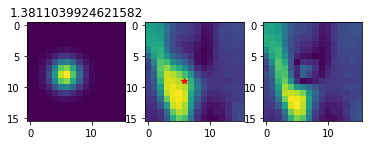

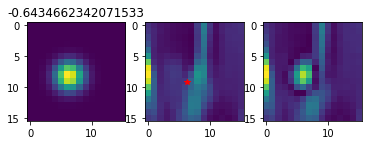

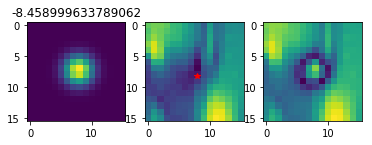

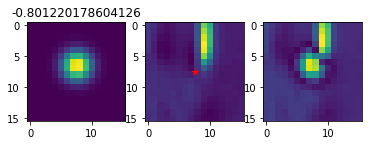

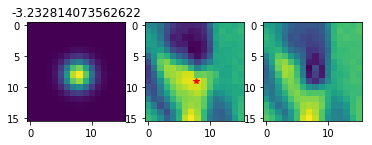

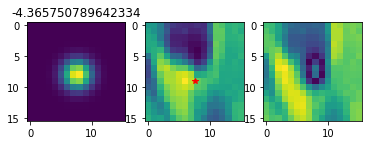

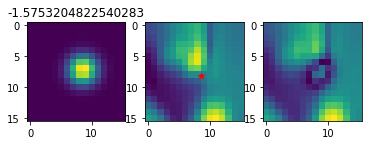

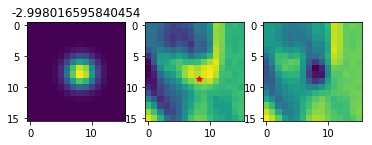

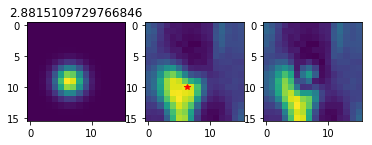

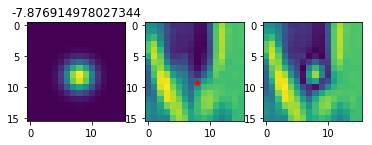

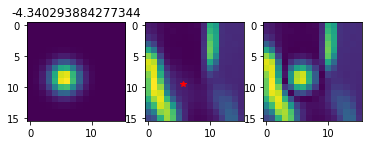

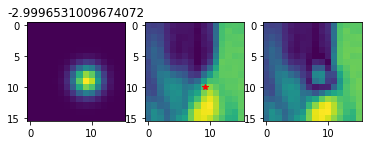

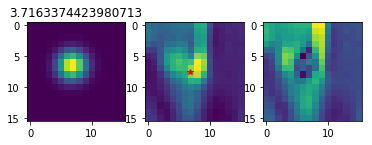

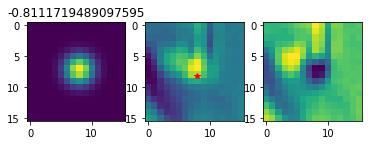

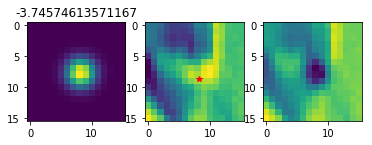

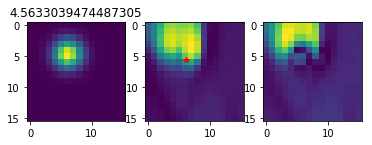

In [135]:
def tensor_to_coord_tensor(X):
    """
    Takes in a 4D image and returns the 3*W*H coordinate representation
    """
    device = X.device
    batch_num, channel_num, height, width = X.shape
    flattened_img = X.permute((0, 1, 3, 2)).contiguous().view(batch_num, channel_num, -1)
    x_coord = torch.arange(0, width).view(width, 1)
    x_coord = x_coord.expand(channel_num, width, height).contiguous()
    x_coord = x_coord.view(channel_num, width * height).float().expand(batch_num, channel_num, -1).to(device)

    y_coord = torch.arange(height, 0, -1) - 1
    y_coord = y_coord.expand(channel_num, width, height).contiguous()
    y_coord = y_coord.view(channel_num, width * height).float().expand(batch_num, channel_num, -1).to(device)

    coord_matrix = torch.stack([x_coord, y_coord, flattened_img])

    return coord_matrix.permute((1, 2, 0, 3))

index = 10
index2 = 0

def gaussian2d_new(shape, mean, covar):
    num_points = shape[0] * shape[1]
    coords = tensor_to_coord_tensor(torch.zeros(1, 1, shape[0], shape[1]))
    coords = coords[0, 0, 0:2, :]
    centered = (coords.t() - mean.expand(shape[0]*shape[1], 2)).view(num_points, 2, 1)
#     print(centered)
    rotated = torch.bmm(covar.expand(num_points, 2, 2), centered)
#     rotated = centered
    value = torch.bmm(centered.permute([0, 2, 1]), rotated)
    value = torch.exp(-1*value.view(shape[0], shape[1]))
    value = value.view(shape[0], shape[1])
    value = value / value.max()
#     print(value)
    return value.t()

def gaussian2d(shape, mean, covar):
    coords = tensor_to_coord_tensor(torch.zeros(1, 1, shape[0], shape[1]))
    coords = coords[0, 0, 0:2, :]
    centered = coords.t() - mean.expand(shape[0]*shape[1], 2)
    rotated = torch.mm(covar.t(), centered.t())
    value = torch.mm(centered, rotated)
    value = torch.exp(-1*torch.diag(value)).view(shape[0], shape[1])
    value = value / value.sum()
    return value.t()
    
weight_values = []
gaussian_kernels = []
for index in range(16):
    means2, orientations2, mu_avg, T_orig, theta, (L1, L2) = pinn.multi_pose(first_features)
    mean = means2[0, index, :, 0].cpu()
    
#     print(orientations[0].shape)
    covar = torch.Tensor([[1, 0], [0, 1]]) * 0.2
#     theta = torch.atan2(orientations2[0, index:index+1, 0, 1], orientations2[0, index:index+1,0, 0])
#     covar = rot_mat_tensor(torch.Tensor([3]))[0].cpu() * 0.1
    V = orientations2[0, index].cpu()
    sigma = torch.Tensor([[L1[0, index], 0],[0, L2[0, index]]])
#     covar = torch.mm(V.t(), torch.mm(sigma, V)) * 10
    
    value = gaussian2d_new((16, 16), mean, covar) - 0.1
    gaussian_kernels.append(value)
    fig, ax = plt.subplots(1, 3)

    input_tensor = first_features[0:1, index:index+1]
    input_tensor = input_tensor / input_tensor.max()
    ellipticality = torch.nn.functional.conv2d(input_tensor, value.view(1, 1, 16, 16).cuda())[0,0,0,0]
    print(torch.nn.functional.mse_loss(value.view(1, 1, 16, 16), input_tensor.cpu()))
    #     ovularity = ((input_tensor - value.view(1, 1, 16, 16).cuda())**2)[0,0,0,0]
    weight_values.append(ellipticality.item())
    ax[0].imshow(utils.tensor_to_numpy_img(value.view(1, 1, 16, 16)))
    ax[1].imshow(utils.tensor_to_numpy_img(input_tensor))
    ax[1].plot(mean[0].data, 16 - mean[1].data, 'r*')
    ax[2].imshow(utils.tensor_to_numpy_img(torch.abs(input_tensor - value.cuda())))
    ax[0].set_title(ellipticality.item())
    


In [28]:
torch.nn.functional.softmax(torch.Tensor(weight_values), dim=0)

tensor([ 2.9938e-02,  3.9880e-03,  1.6305e-06,  3.0119e-03,  2.9604e-04,
         8.0603e-05,  1.1538e-03,  2.9506e-04,  1.1449e-01,  2.8719e-06,
         1.0082e-04,  3.8486e-04,  1.8776e-01,  3.5372e-03,  1.4556e-04,
         6.5481e-01])

torch.Size([2, 1])
torch.Size([16, 2, 1])


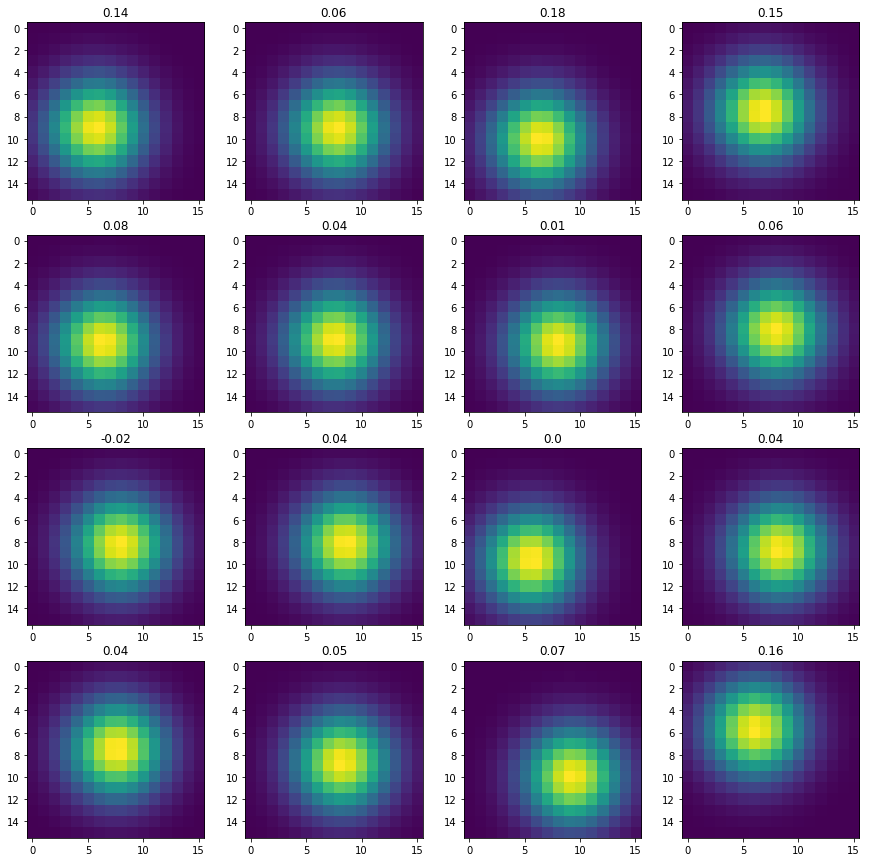

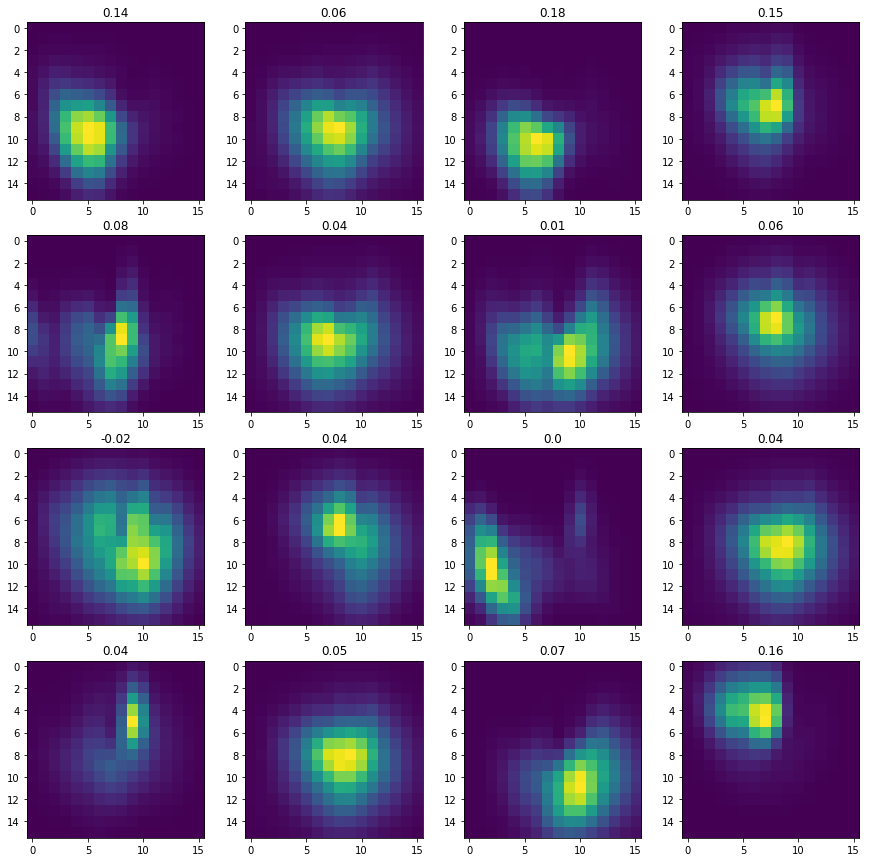

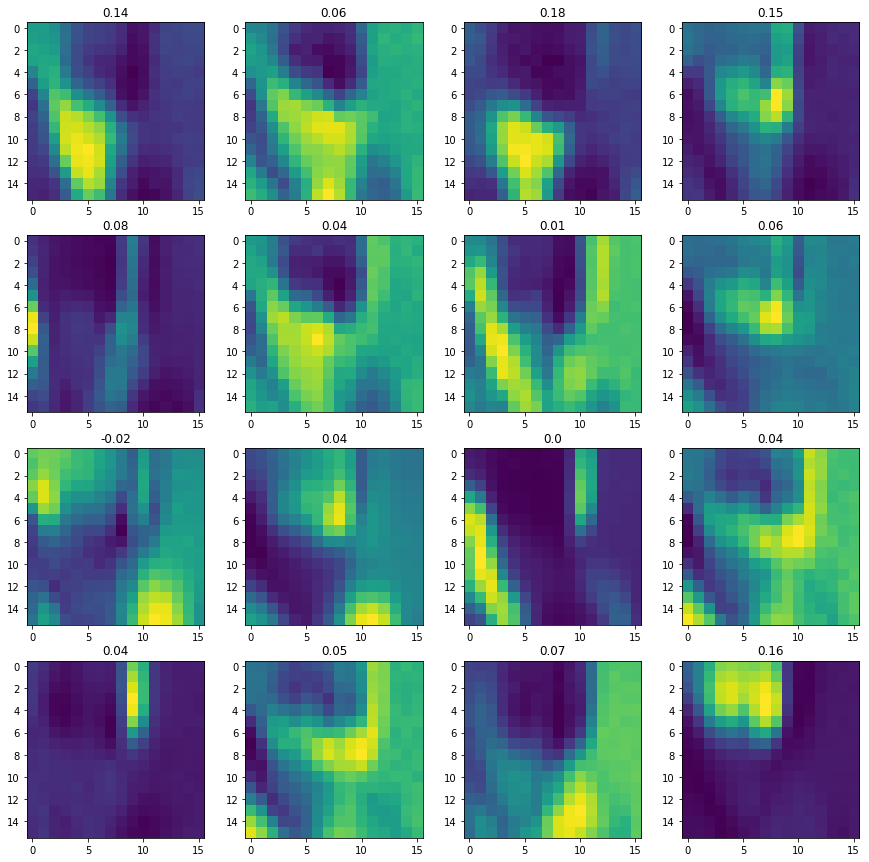

In [171]:
import math

def get_gaussian_kernel(mean, kernel_size=16, sigma=2, channels=1):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    channels = mean.shape[0]
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()
    xy_grid = xy_grid.repeat(channels, 1, 1, 1)
    mean = mean.view(channels, 1, 1, 2)
#     mean = (kernel_size - 1)/2.
#     mean = torch.Tensor([[2, 14], [8, 8], [14, 2]])
    variance = sigma**2.
    
#     print(mean.unsqueeze(1).unsqueeze(1).shape)
    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.max(gaussian_kernel)
    gaussian_kernel = gaussian_kernel - 10

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(channels, 1, kernel_size, kernel_size)
    
    return gaussian_kernel

# mean = torch.Tensor([[2, 14], [7, 1], [14, 2]])
mean = torch.Tensor([[0], [16]]) + means2[0].cpu()*torch.Tensor([[1], [-1]])
print(torch.Tensor([[0], [16]]).shape)
# mean = means2[0].cpu()
print(mean.shape)
gaussian = get_gaussian_kernel(mean=mean, sigma=3)
# fig, ax = plt.subplots(1, means2[0].shape[0])
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
fig2, ax2 = plt.subplots(4, 4, figsize=(15, 15))
fig3, ax3 = plt.subplots(4, 4, figsize=(15, 15))
for index in range(16):
    first_features[0, index] = torch.abs(first_features[0, index])
    first_features[0, index] = first_features[0, index] / first_features[0, index].sum()
    ax[index % 4, index // 4].imshow(utils.tensor_to_numpy_img(gaussian[index:index+1]))
    ax2[index % 4, index // 4].imshow(utils.tensor_to_numpy_img((first_features[0, index].cpu() * gaussian[index, 0])))
    ax3[index % 4, index // 4].imshow(utils.tensor_to_numpy_img((first_features[0, index].cpu())))
#     print(first_features[0, index].cpu().max())
    overlap = (first_features[0, index].cpu() * (gaussian[index, 0] - 0.2)).sum()
#     print(overlap)
    ax[index % 4, index // 4].set_title(np.round(overlap.item(), 2))
    ax2[index % 4, index // 4].set_title(np.round(overlap.item(), 2))
    ax3[index % 4, index // 4].set_title(np.round(overlap.item(), 2))
    #     print(gaussian_conv.weight.data.min())
# gaussian_conv(first_features.cpu())